# Exercise 1

Design: Propose a logging schema for Sqwish’s online learning system. It should record everything needed to reproduce training and do later analysis. For each user request, what would you log? (Think: a unique request ID, user context features, chosen prompt/model, all model outputs maybe, any user click or outcome, timestamps, the probability or propensity of the chosen action if using a stochastic policy, etc.). Write a structured list of fields and justify each (why is it needed? e.g. propensity is needed for IPS in OPE).

## Solution

## Solution: Logging schema (concise)

### Decision event (one row per request)
- `request_id`, `timestamp_ms`, `session_id`, `user_id_hash` (join keys: link this decision to later rewards/errors)
- `trace_id` (distributed tracing: follow the request across services and break down latency)
- `context_features`, `feature_version` (exact inputs the policy used at decision time)
- `candidate_actions`, `chosen_action`, `action_params` (what was available + what we did)
- `logging_policy_id`, `logging_policy_version`, `propensity` (needed for IPS/DR OPE)
- `exploration_state` (epsilon/UCB alpha/TS params; why it explored)
- `latency_ms_total`, `latency_ms_by_stage`, `token_usage`, `estimated_cost_usd`, `error_flags`
- `safety_labels`, `safety_score`, `safety_model_version`, `mitigation_taken`

### Reward/outcome event (separate row, can arrive later)
- `request_id` (join key: attach this outcome back to the original decision)
- `reward_timestamp_ms` (when the outcome was observed)
- `reward_type`, `reward_value` (what happened + numeric value)
- `reward_observation_window` (what window you waited for, e.g. 24h conversion)
- `attribution_model_version` (if credit assignment/labeling uses a model)

### Minimal template
```json
{
  "request_id": "...",
  "timestamp_ms": 0,
  "session_id": "...",
  "user_id_hash": "...",
  "context_features": {"...": "..."},
  "feature_version": "...",
  "candidate_actions": ["..."],
  "chosen_action": "...",
  "action_params": {"...": "..."},
  "logging_policy_id": "...",
  "logging_policy_version": "...",
  "propensity": 0.0,
  "latency_ms_total": 0,
  "token_usage": {"prompt": 0, "completion": 0},
  "estimated_cost_usd": 0.0,
  "safety_labels": [],
  "error_flags": []
}
```



# Exercise 2

Analysis: You have deployed a bandit that optimizes prompts. After a week, you examine results and see overall user satisfaction went up 5%. However, for new users (first-time visitors) satisfaction dropped. How would you investigate this? Outline an experiment or analysis using logs to diagnose why the policy might be underperforming for new users (maybe it over-explored or didn’t personalize properly for cold-start users). What changes to the algorithm could you consider (e.g. epsilon-greedy for new users until enough data)?

## Solution

## Solution

### Investigation (logs-first)
- Slice new-user satisfaction by query bucket/intent and by `logging_policy_version` to find when/where the drop starts.
- Compare new vs returning behavior: `chosen_action` mix and `exploration_state`.
- Check labels: reward delay (`reward_timestamp_ms - timestamp_ms`) and missing outcomes for new users.
- Before shipping changes, estimate the fix with OPE (IPS/DR) using logged `propensity`.

### One mitigation
- New-user safe exploration: for `is_new_user`, keep exploration small (e.g., low `epsilon`) and only explore within a shortlist of “safe” prompts; don’t try risky/untested prompts on first-time users.

### Rollout + monitoring
- Canary to a small % of new-user traffic; watch new-user satisfaction and overall as a sanity check.



# Exercise 3

Coding: Using an open bandit dataset (e.g. the Open Bandit Pipeline’s logged data if available, or simulate one), perform an off-policy evaluation of a hypothetical new policy. For example, use logged data from a uniform random policy on a classification task as bandit feedback. Define a new deterministic policy (like always choose arm 1 for certain feature values and arm 2 otherwise). Use IPS and Doubly Robust to estimate the new policy’s reward from the logs. Compare that to the actual reward if you run the new policy on the dataset (if ground truth available). This exercise solidifies understanding of OPE’s value and limitations (if the policy is very different, IPS variance will be high).

## Solution

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


Loaded OBD with behavior_policy='bts', campaign='all'

--- OBD: quick stats ---
n_rounds:  10,000
n_actions: 80
context shape: (10000, 22)
reward mean (click rate): 0.0042
pscore quantiles:
min    0.000045
p01    0.000955
p05    0.003410
p50    0.064455
p95    0.342968
p99    0.714599
max    0.954240
dtype: float64
context NaN rate: 0.000000


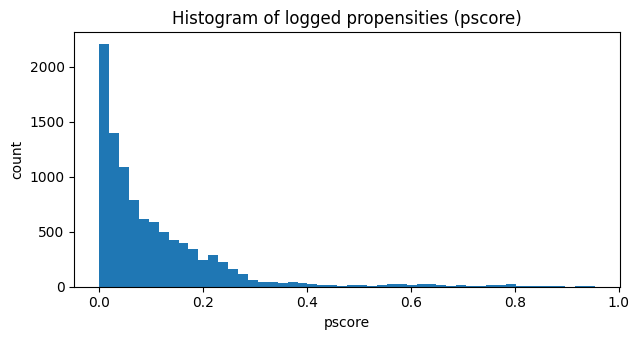

In [5]:
# Exercise 3: Off-Policy Evaluation (OPE) with Open Bandit Dataset (OBD)

import sys
import subprocess
import importlib.util


def _pip_install(pkg: str) -> tuple[int, str]:
    cmd = [sys.executable, "-m", "pip", "install", "--quiet", pkg]
    res = subprocess.run(cmd, capture_output=True, text=True)
    return res.returncode, (res.stderr or res.stdout or "").strip()


def _ensure_pkg(pkg: str, alt_pkgs: list[str] | None = None) -> None:
    if importlib.util.find_spec(pkg) is not None:
        return

    # Try the primary package name first.
    code, msg = _pip_install(pkg)
    if code == 0:
        return

    # Try alternate package names if provided.
    if alt_pkgs:
        for alt in alt_pkgs:
            code, msg = _pip_install(alt)
            if code == 0:
                return

    raise RuntimeError(
        "Package install failed. Try manually in a terminal:\n"
        f"  {sys.executable} -m pip install {pkg}\n"
        "If this is a network issue, you may need internet access or a local wheel.\n"
        f"pip output:\n{msg}"
    )


# Core libs
# Pin numpy to avoid environment-specific partial installs (e.g., missing numpy.char)
_ensure_pkg("numpy", alt_pkgs=["numpy<2.0"])
_ensure_pkg("pandas")
# OBP pulls seaborn, which expects matplotlib to have register_cmap; pin to a compatible version.
_ensure_pkg("matplotlib", alt_pkgs=["matplotlib<3.8"])
_ensure_pkg("scikit-learn")

# Some environments end up with a broken NumPy/Scipy pair (e.g., missing numpy.char).
# Force-reinstall pinned versions if we detect that issue.

def _fix_numpy_scipy() -> None:
    try:
        import numpy as np
        _ = np.char  # fails if numpy is broken
        import scipy  # noqa: F401
        return
    except Exception:
        # Remove broken installs (pip reinstall can leave corrupted files behind)
        import site
        import glob
        import shutil

        for sp in site.getsitepackages() + [site.getusersitepackages()]:
            for path in glob.glob(str(sp) + "/numpy*"):
                shutil.rmtree(path, ignore_errors=True)
            for path in glob.glob(str(sp) + "/scipy*"):
                shutil.rmtree(path, ignore_errors=True)

        subprocess.check_call(
            [
                sys.executable,
                "-m",
                "pip",
                "install",
                "--no-cache-dir",
                "--upgrade",
                "numpy==1.26.4",
                "scipy==1.10.1",
            ]
        )
        # Clear cached modules so the fresh installs load.
        for m in ["numpy", "scipy"]:
            if m in sys.modules:
                del sys.modules[m]


_fix_numpy_scipy()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OBP (Open Bandit Pipeline)
# Try a couple common package names in case the default fails.
_ensure_pkg("obp", alt_pkgs=["open-bandit-pipeline"])

from obp.dataset import OpenBanditDataset


# --- Load dataset ---
# We pick a default that tends to work reliably; if one behavior_policy fails, try another.
last_err = None
obd = None
for behavior_policy in ["bts", "random"]:
    try:
        obd = OpenBanditDataset(behavior_policy=behavior_policy, campaign="all")
        print(f"Loaded OBD with behavior_policy={behavior_policy!r}, campaign='all'")
        break
    except Exception as e:
        last_err = e

if obd is None:
    raise RuntimeError(f"Failed to load OpenBanditDataset: {last_err}")

bandit_feedback = obd.obtain_batch_bandit_feedback()

# --- Basic dataset analysis (EDA) ---
a = np.asarray(bandit_feedback["action"]).astype(int)
r = np.asarray(bandit_feedback["reward"]).astype(float)
pscore = np.asarray(bandit_feedback["pscore"]).astype(float)
X = np.asarray(bandit_feedback["context"]).astype(float)

n_rounds = int(bandit_feedback.get("n_rounds", len(a)))
n_actions = int(bandit_feedback.get("n_actions", int(a.max()) + 1))

print("\n--- OBD: quick stats ---")
print(f"n_rounds:  {n_rounds:,}")
print(f"n_actions: {n_actions:,}")
print(f"context shape: {X.shape}")
print(f"reward mean (click rate): {r.mean():.4f}")

q = np.quantile(pscore, [0.0, 0.01, 0.05, 0.5, 0.95, 0.99, 1.0])
print("pscore quantiles:")
print(pd.Series(q, index=["min", "p01", "p05", "p50", "p95", "p99", "max"]))

nan_rate = float(np.isnan(X).mean())
print(f"context NaN rate: {nan_rate:.6f}")

plt.figure(figsize=(6.5, 3.5))
plt.hist(pscore, bins=50)
plt.title("Histogram of logged propensities (pscore)")
plt.xlabel("pscore")
plt.ylabel("count")
plt.tight_layout()
plt.show()



In [ ]:

K = 5
counts = np.bincount(a, minlength=n_actions)
topk = counts.argsort()[-K:][::-1]
print(f"Top-{K} actions by frequency: {topk.tolist()} (counts={counts[topk].tolist()})")

mask = np.isin(a, topk)
aK_raw = a[mask]
rK = r[mask]
psK = pscore[mask]
XK = X[mask]

# Remap action ids to {0..K-1}
a_map = {int(act): i for i, act in enumerate(topk)}
aK = np.vectorize(a_map.get)(aK_raw).astype(int)

print(f"\n--- After filtering to {K} actions ---")
print(f"n_rounds_K: {len(aK):,}")
print(f"reward mean: {rK.mean():.4f}")
print("pscore quantiles (filtered rows):")
print(pd.Series(np.quantile(psK, [0.0, 0.01, 0.5, 0.99, 1.0]), index=["min", "p01", "p50", "p99", "max"]))

# --- Define a deterministic target policy ---
# Bucket context[0] into K quantiles -> action in {0..K-1}
x0 = XK[:, 0]
edges = np.quantile(x0, np.linspace(0, 1, K + 1))
a_tgt = np.digitize(x0, edges[1:-1], right=True)

print("\nTarget policy rule:")
print(f"  choose action=bin(context[0], {K} quantiles)")
print("Target policy action rate:")
print(pd.Series(a_tgt).value_counts(normalize=True).sort_index())



Top-5 actions by frequency: [51, 39, 7, 61, 59] (counts=[1105, 756, 741, 704, 651])

--- After filtering to 5 actions ---
n_rounds_K: 3,957
reward mean: 0.0053
pscore quantiles (filtered rows):
min    0.001590
p01    0.010483
p50    0.143990
p99    0.663412
max    0.867205
dtype: float64

Target policy rule:
  choose action=bin(context[0], 5 quantiles)
Target policy action rate:
0    1.0
dtype: float64


Using n=3,957 rows for OPE with K=5

Point estimates:
  IPS: 0.022404
  DR : 0.013144

OPE estimates with 95% bootstrap CIs:
estimator  estimate  ci95_low  ci95_high
      IPS  0.022404  0.001638   0.058908
       DR  0.013144 -0.008720   0.048285


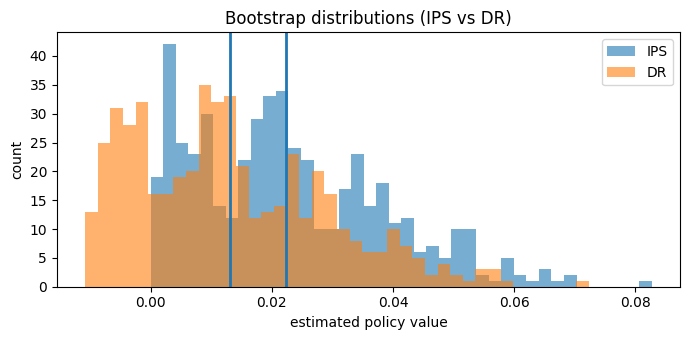

In [7]:
# --- OPE: IPS + Doubly Robust (DR) with bootstrap confidence intervals ---

from sklearn.linear_model import LogisticRegression

# For numerical stability if some propensities are tiny.
psK_clip = np.clip(psK, 1e-6, None)

# (Optional) subsample for speed if the filtered dataset is huge.
# This keeps the notebook snappy while still demonstrating OPE.
max_n = 50_000
if len(aK) > max_n:
    rng = np.random.default_rng(0)
    idx = rng.choice(len(aK), size=max_n, replace=False)
    aK_s = aK[idx]
    rK_s = rK[idx]
    psK_s = psK_clip[idx]
    XK_s = XK[idx]
    a_tgt_s = a_tgt[idx]
else:
    aK_s, rK_s, psK_s, XK_s, a_tgt_s = aK, rK, psK_clip, XK, a_tgt

K = int(aK_s.max()) + 1
print(f"Using n={len(aK_s):,} rows for OPE with K={K}")

# Reward model q_hat(x,a) for DR.
# For K actions, use one-hot encoding for the action feature.
A_onehot = np.eye(K, dtype=float)[aK_s]
X_aug = np.hstack([XK_s, A_onehot])

rm = LogisticRegression(max_iter=1000)
rm.fit(X_aug, rK_s)


def q_hat(X_ctx: np.ndarray, a_val: int) -> np.ndarray:
    a_one = np.eye(K, dtype=float)[np.full(X_ctx.shape[0], int(a_val))]
    X_aug_local = np.hstack([X_ctx, a_one])
    return rm.predict_proba(X_aug_local)[:, 1]


q_logged = np.array([q_hat(XK_s, ai) for ai in aK_s])
q_tgt = np.array([q_hat(XK_s, ai) for ai in a_tgt_s])

# IPS
w = (aK_s == a_tgt_s).astype(float) / psK_s
ips_hat = float(np.mean(w * rK_s))

# DR
dr_terms = q_tgt + (aK_s == a_tgt_s).astype(float) / psK_s * (rK_s - q_logged)
dr_hat = float(np.mean(dr_terms))

print("\nPoint estimates:")
print(f"  IPS: {ips_hat:.6f}")
print(f"  DR : {dr_hat:.6f}")

# --- Bootstrap CIs ---
B = 500
rng = np.random.default_rng(1)
ips_bs = np.empty(B, dtype=float)
dr_bs = np.empty(B, dtype=float)

n = len(aK_s)
for b in range(B):
    ii = rng.integers(0, n, size=n)

    a_b = aK_s[ii]
    r_b = rK_s[ii]
    p_b = psK_s[ii]
    tgt_b = a_tgt_s[ii]

    # Use the same fitted reward model inside bootstrap for speed.
    q_logged_b = q_logged[ii]
    q_tgt_b = q_tgt[ii]

    w_b = (a_b == tgt_b).astype(float) / p_b
    ips_bs[b] = float(np.mean(w_b * r_b))

    dr_b = q_tgt_b + (a_b == tgt_b).astype(float) / p_b * (r_b - q_logged_b)
    dr_bs[b] = float(np.mean(dr_b))


def ci95(x: np.ndarray) -> tuple[float, float]:
    lo, hi = np.percentile(x, [2.5, 97.5])
    return float(lo), float(hi)

ips_lo, ips_hi = ci95(ips_bs)
dr_lo, dr_hi = ci95(dr_bs)

results = pd.DataFrame(
    {
        "estimator": ["IPS", "DR"],
        "estimate": [ips_hat, dr_hat],
        "ci95_low": [ips_lo, dr_lo],
        "ci95_high": [ips_hi, dr_hi],
    }
)
print("\nOPE estimates with 95% bootstrap CIs:")
print(results.to_string(index=False))

# Plot bootstrap distributions
plt.figure(figsize=(7.0, 3.5))
plt.hist(ips_bs, bins=40, alpha=0.6, label="IPS")
plt.hist(dr_bs, bins=40, alpha=0.6, label="DR")
plt.axvline(ips_hat, linewidth=2)
plt.axvline(dr_hat, linewidth=2)
plt.title("Bootstrap distributions (IPS vs DR)")
plt.xlabel("estimated policy value")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()



# Exercise 4

Monitoring: List 3 metrics you would put on a dashboard for the live Sqwish system and why. For example: “Cumulative regret” - to watch if the learning is improving over a non-learning baseline; “10th percentile reward” - to ensure we’re not badly serving a subset of users even if average looks good; “Unsafe response count per 1000 interactions” - to catch any increase in policy violations. Explain briefly how each metric helps ensure the system is healthy.

## Solution

## Solution

- Quality: average reward plus p10/p50/p90/p99, sliced by new vs returning users, averages can hide a bad tail.
- Latency: p50/p90/p95/p99 end-to-end and ttft latency.
- Cost: cost per request.

